In [3]:
from __future__ import print_function
#from builtins import range
#from builtins import object
import numpy as np

In [4]:
class LegCache(object):
    def __init__(self):
        self.d = {}
        pass

    def prep_legendre(self, n, polyorder):
        p = (n, polyorder)
        if p not in self.d:
            self.d[p] = prep_legendre(n, polyorder)
        return self.d[p]

In [5]:
def prep_legendre(n, polyorder):
    '''make array of legendre's'''
    legendres = np.empty([n, polyorder + 1])
    legendres[:, 0] = np.ones(n)
    if polyorder > 0:
        legendres[:, 1] = np.linspace(-1, 1, n)
    for i in range(polyorder - 1):
        l = i + 1
        legendres[:,
                  l + 1] = ((2 * l + 1) * legendres[:,
                                                    1] * legendres[:,
                                                                   l] - l * legendres[:,
                                                                                      l - 1]) / (l + 1)

    q, r = np.linalg.qr(legendres)
    rinv = np.linalg.inv(r)
    qt = q.T.copy()
    return legendres, rinv, qt

In [6]:
def poly_filter_array(
        array,
        mask_remove,
        mask,
        scan_list,
        ibegin,
        polyorder,
        minfrac=.75):
    """ writes over input array
    """
    nold = -1
    # do nothing
    if polyorder < 0:
        return array
    #damn, work
    nch = array.shape[0]
    nt = array.shape[1]
    ns = len(scan_list)

    coeff_out = np.zeros((nch, ns, polyorder + 1))

    legcache = LegCache()

    # remove mean
    if polyorder == 0:
        for s in range(len(scan_list)):
            istart, n = scan_list[s]
            start = istart - ibegin
#			array[:,start:start+n] -= tile(np.mean(array[:,start:start+n]*mask[:,start:start+n],axis=1).reshape(nch,1),[1,n])
            for i in range(nch):
                if np.any(mask[i, start:start + n]):
                    mean = np.average(
                        array[i, start:start + n], weights=mask[i, start:start + n])
                    array[i, start:start + n] -= mean
                    coeff_out[i, s, 0] = mean

    # other cases
    if polyorder > 0:
        for s in range(len(scan_list)):
            istart, n = scan_list[s]
            start = istart - ibegin
            if n <= polyorder:  # otherwise cannot compute legendre polynomials
                for i in range(nch):
                    mask[i, start:start + n] = 0  # flag it
                    # remove this region from actual data as well
                    mask_remove[i, start:start + n] = 0
                    print('Not enough points (%d) to build legendre of order (%d)' % (n, polyorder))
                continue
            goodhits = np.sum(mask[:, start:start + n], axis=1)
            if n != nold:
                legendres, rinv, qt = legcache.prep_legendre(n, polyorder)
                rinvqt = np.dot(rinv, qt)
                nold = n
            # handle no masked ones

            for i in range(nch):
                if goodhits[i] != n:
                    continue  # skip for now
                # filter_slice_legendre_qr_nomask_precalc_inplace(array[i,start:start+n],legendres,rinvqt)
                bolo = array[i, start:start + n]
                coeff = np.dot(rinvqt, bolo)
                coeff_out[i, s, :] = coeff
                bolo -= np.dot(legendres, coeff)
#				array[i,start:start+n] = filter_slice_legendre_qr_nomask_precalc(
#					array[i,start:start+n], legendres,rinv,qt)

            for i in range(nch):
                if goodhits[i] == n:
                    continue  # skip since dealt with above
                if goodhits[i] < minfrac * n:  # not enough points
                    mask[i, start:start + n] = 0  # flag it
                    # remove this region from actual data as well
                    mask_remove[i, start:start + n] = 0
                    continue
                bolo, coeff = filter_slice_legendre_qr_mask_precalc(
                    array[i, start:start + n], mask[i, start:start + n], legendres)
                array[i, start:start + n] = bolo
                coeff_out[i, s, :] = coeff
    return coeff_out

In [7]:
import numpy as np
from numpy.testing import assert_allclose

def assertIdenticalList(list1, list2):
    for i, list1i in enumerate(list1):
        if isinstance(list1i, bool):
            assert list1i is list2[i]
        else:
            assert_allclose(list1i, list2[i], rtol=1e-03)

In [8]:
import pickle
import sys
py2 = sys.version_info[0] == 2

def test_poly_filter_array():
    with open('tests/timestream/poly_filter_array_input.pkl', 'rb') as f:
        if not py2:
            poly_filter_array_input = pickle.load(
                f, encoding='latin1')
        else:
            poly_filter_array_input = pickle.load(f)
    with open('tests/timestream/poly_filter_array_output.pkl', 'rb') as f:
        if not py2:
            poly_filter_array_output = pickle.load(
                f, encoding='latin1')
        else:
            poly_filter_array_output = pickle.load(f)
    poly_filter_array(*poly_filter_array_input)
    assertIdenticalList(
       poly_filter_array_input,
        poly_filter_array_output)

    # debug
    return poly_filter_array_input, poly_filter_array_output

In [9]:
with open('tests/timestream/poly_filter_array_input.pkl', 'rb') as f:
    poly_filter_array_input = pickle.load(f)
with open('tests/timestream/poly_filter_array_output.pkl', 'rb') as f:
    poly_filter_array_output = pickle.load(f)

In [10]:
for i in poly_filter_array_input:
    print(type(i), i)

<type 'numpy.ndarray'> [[ 0.00535836  0.00064484 -0.00012384 ..., -0.00300279  0.00138122
  -0.00629981]]
<type 'numpy.ndarray'> [[False False False ..., False False False]]
<type 'numpy.ndarray'> [[False False False ..., False False False]]
<type 'list'> [(171, 397), (579, 398), (988, 397), (1396, 397), (1804, 398), (2213, 397), (2621, 397), (3029, 398), (3438, 397), (3846, 397), (4254, 398), (4663, 397), (5071, 397), (5479, 398), (5888, 397), (6296, 397), (6704, 398), (7113, 397), (7521, 397), (7929, 398), (8338, 397), (8746, 397), (9154, 398), (9563, 397), (9971, 397), (10379, 300)]
<type 'int'> 0
<type 'int'> 1
<type 'float'> 0.75


In [11]:
for i in poly_filter_array_output:
    print(type(i), i)

<type 'numpy.ndarray'> [[ 0.00535836  0.00064484 -0.00012384 ..., -0.00300279  0.00138122
  -0.00629981]]
<type 'numpy.ndarray'> [[False False False ..., False False False]]
<type 'numpy.ndarray'> [[False False False ..., False False False]]
<type 'list'> [(171, 397), (579, 398), (988, 397), (1396, 397), (1804, 398), (2213, 397), (2621, 397), (3029, 398), (3438, 397), (3846, 397), (4254, 398), (4663, 397), (5071, 397), (5479, 398), (5888, 397), (6296, 397), (6704, 398), (7113, 397), (7521, 397), (7929, 398), (8338, 397), (8746, 397), (9154, 398), (9563, 397), (9971, 397), (10379, 300)]
<type 'int'> 0
<type 'int'> 1
<type 'float'> 0.75


In [12]:
for i, __ in enumerate(poly_filter_array_input):
    print(np.array_equal(poly_filter_array_input[i], poly_filter_array_output[i]))

False
True
True
True
True
True
True


In [13]:
for i in poly_filter_array_input:
    if type(i) == np.ndarray:
        print(i.dtype)

float64
bool
bool


In [14]:
input_array, mask_remove, mask, scan_list, ibegin, polyorder, minfrac = poly_filter_array_input

In [15]:
input_array

array([[ 0.00535836,  0.00064484, -0.00012384, ..., -0.00300279,
         0.00138122, -0.00629981]])

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt

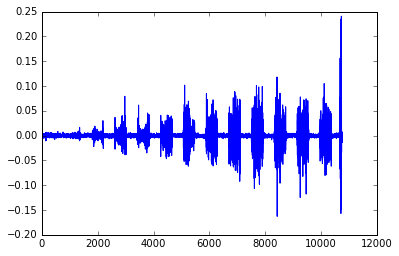

In [17]:
plt.plot(input_array[0])

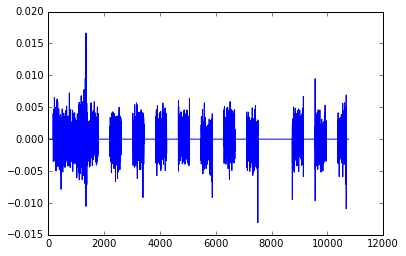

In [18]:
plt.plot(input_array[0] * mask[0])

In [29]:
poly_filter_array_output[0][0]

array([ 0.00535836,  0.00064484, -0.00012384, ..., -0.00300279,
        0.00138122, -0.00629981])

In [28]:
input_array[0]

array([ 0.00535836,  0.00064484, -0.00012384, ..., -0.00300279,
        0.00138122, -0.00629981])

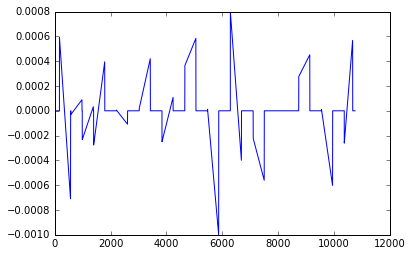

In [32]:
plt.plot(input_array[0]-poly_filter_array_output[0][0])

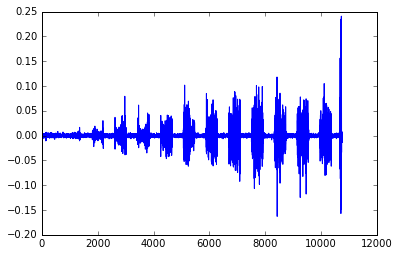

In [33]:
plt.plot(poly_filter_array_output[0][0])